In [1]:
!pip install openml

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [222]:
import openml
import pandas as pd
import numpy as np
import random
from abc import ABC

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from jenga.basis import BinaryClassificationTask
from jenga.corruptions.generic import MissingValues, SwappedValues
from jenga.corruptions.numerical import Scaling

### Datasets

In [84]:
data = openml.datasets.get_dataset("credit-g")

In [4]:
data

OpenML Dataset
Name..........: credit-g
Version.......: 1
Format........: ARFF
Upload Date...: 2014-04-06 23:21:47
Licence.......: Public
Download URL..: https://www.openml.org/data/v1/download/31/credit-g.arff
OpenML URL....: https://www.openml.org/d/31
# of features.: 21
# of instances: 1000

In [5]:
## summary
print(f"Dataset '{data.name}', target: '{data.default_target_attribute}'")
print(data.description[:500])

Dataset 'credit-g', target: 'class'
**Author**: Dr. Hans Hofmann  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)

**German Credit data**  
This dataset classifies people described by a set of attributes as good or bad credit risks.

This dataset comes with a cost matrix: 
``` 
      Good  Bad (predicted)  
Good   0    1   (actual)  
Bad    5    0  
```

It is worse to class a customer as good when they a


In [6]:
## load the data
# X: An array/dataframe where each row represents one example with the corresponding feature values
# y: the classes for each example
# categorical_indicator - an array that indicates which feature is categorical
# attribute_names - the names of the features for the examples(X) and target feature (y)

X, y, categorical_indicator, attribute_names = data.get_data(
    dataset_format='dataframe',
    target=data.default_target_attribute
)

In [7]:
X

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,4.0,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,4.0,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,4.0,car,38.0,none,own,1.0,skilled,1.0,none,yes
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,4.0,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes


In [8]:
y

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: category
Categories (2, object): [good < bad]

In [19]:
all_data = X.copy(deep=True)
all_data['class'] = y
all_data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12.0,existing paid,furniture/equipment,1736.0,<100,4<=X<7,3.0,female div/dep/mar,none,...,real estate,31.0,none,own,1.0,unskilled resident,1.0,none,yes,good
996,<0,30.0,existing paid,used car,3857.0,<100,1<=X<4,4.0,male div/sep,none,...,life insurance,40.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes,good
997,no checking,12.0,existing paid,radio/tv,804.0,<100,>=7,4.0,male single,none,...,car,38.0,none,own,1.0,skilled,1.0,none,yes,good
998,<0,45.0,existing paid,radio/tv,1845.0,<100,1<=X<4,4.0,male single,none,...,no known property,23.0,none,for free,1.0,skilled,1.0,yes,yes,bad


In [10]:
attribute_names

['checking_status',
 'duration',
 'credit_history',
 'purpose',
 'credit_amount',
 'savings_status',
 'employment',
 'installment_commitment',
 'personal_status',
 'other_parties',
 'residence_since',
 'property_magnitude',
 'age',
 'other_payment_plans',
 'housing',
 'existing_credits',
 'job',
 'num_dependents',
 'own_telephone',
 'foreign_worker']

In [11]:
categorical_indicator

[True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True]

In [30]:
attribute_types = pd.DataFrame(attribute_names, columns=["attribute_names"])
attribute_types['categorical_indicator'] = categorical_indicator
display(attribute_types)

,attribute_names,categorical_indicator
0,checking_status,True
1,duration,False
2,credit_history,True
3,purpose,True
4,credit_amount,False
5,savings_status,True
6,employment,True
7,installment_commitment,False
8,personal_status,True
9,other_parties,True


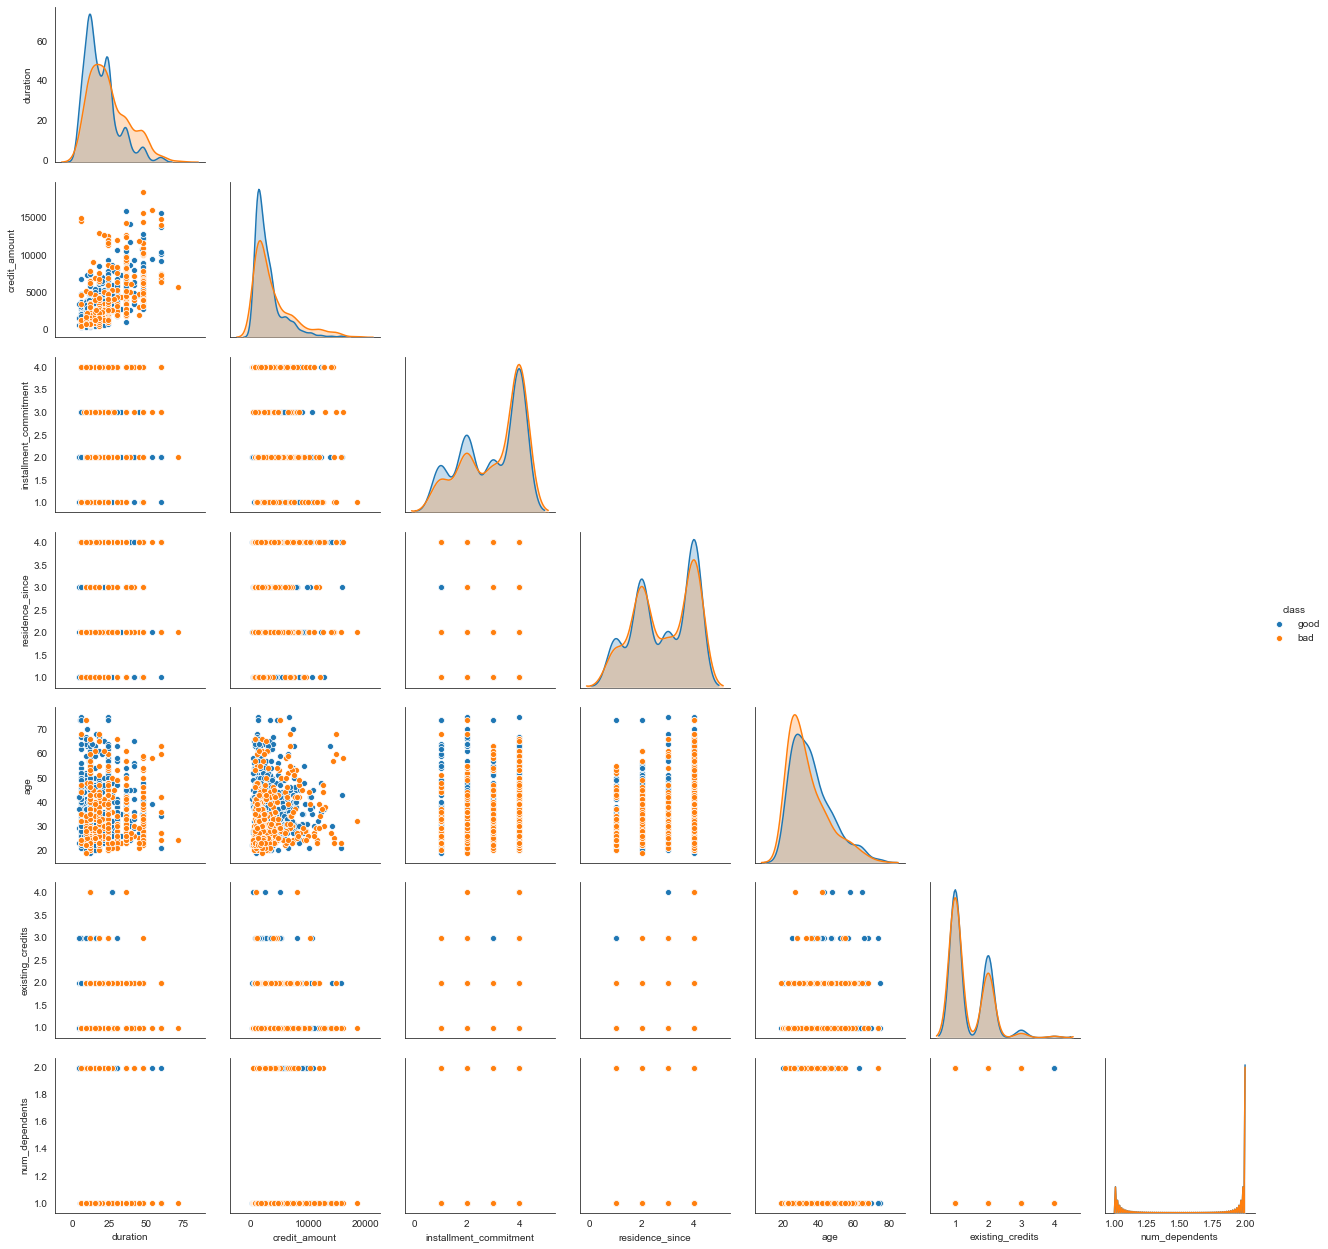

In [221]:
sns.set_style("white") # grid/no grid style: darkgrid, whitegrid, dark, white, ticks

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

plot = sns.pairplot(all_data, hue="class")
plot.map_upper(hide_current_axis)
plt.show()

In [60]:
def get_alldata(dataset_name):
    ''' Get dataset from the OpenML Datasets and tranform it for use.
    
    Params:
    dataset_name: str: name of the dataset
    
    Returns:
    all_data: dataframe: combined data and labels
    attribute_names: list: names of attributes from the data
    attribute_types: dataframe: names and types of attributes from the data 
    '''
    
    data = openml.datasets.get_dataset(dataset_name)
    
    ## summary
    print(f"Dataset '{data.name}', target: '{data.default_target_attribute}'")
    print(data.description[:500])
    
    ## load the data
    # X: An array/dataframe where each row represents one example with the corresponding feature values
    # y: the classes for each example
    # categorical_indicator - an array that indicates which feature is categorical
    # attribute_names - the names of the features for the examples(X) and target feature (y)
    X, y, categorical_indicator, attribute_names = data.get_data(
        dataset_format='dataframe',
        target=data.default_target_attribute
    )
    
    ## combine the attribute names with the information of them being categorical or not
    # will be used further in order not to manually distinguish between the numerical and categorical features
    attribute_types = pd.DataFrame(attribute_names, columns=["attribute_names"])
    attribute_types['categorical_indicator'] = categorical_indicator
    print("\nAttribute types: ")
    display(attribute_types)
    
    all_data = X.copy(deep=True)
    all_data['class'] = y
    
    return all_data, attribute_names, attribute_types

In [66]:
## test credit-g dataset (openML)
all_data, attribute_names, attribute_types = get_alldata("credit-g")
print(attribute_names)
display(attribute_types)
display(all_data.head())

Dataset 'credit-g', target: 'class'
**Author**: Dr. Hans Hofmann  

**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)) - 1994    

**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html)



**German Credit data**  

This dataset classifies people described by a set of attributes as good or bad credit risks.



This dataset comes with a cost matrix: 

``` 

      Good  Bad (predicted)  

Good   0    1   (actual)  

Bad    5    0  

```



It is worse to class a customer as go

Attribute types: 


,attribute_names,categorical_indicator
0,checking_status,True
1,duration,False
2,credit_history,True
3,purpose,True
4,credit_amount,False
5,savings_status,True
6,employment,True
7,installment_commitment,False
8,personal_status,True
9,other_parties,True


['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']


,attribute_names,categorical_indicator
0,checking_status,True
1,duration,False
2,credit_history,True
3,purpose,True
4,credit_amount,False
5,savings_status,True
6,employment,True
7,installment_commitment,False
8,personal_status,True
9,other_parties,True


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,...,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [67]:
## test blood-transfusion-service-center dataset (openML)
all_data_bloodtransfusion, attribute_names_bloodtransfusion, attribute_types_bloodtransfusion = get_alldata("blood-transfusion-service-center")
print(attribute_names_bloodtransfusion)
display(attribute_types_bloodtransfusion)
all_data_bloodtransfusion.head()

Dataset 'blood-transfusion-service-center', target: 'Class'
**Author**: Prof. I-Cheng Yeh  

**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center)  

**Please cite**: Yeh, I-Cheng, Yang, King-Jang, and Ting, Tao-Ming, "Knowledge discovery on RFM model using Bernoulli sequence", Expert Systems with Applications, 2008.   



**Blood Transfusion Service Center Data Set**  

Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan -- this is a classification problem.



To demonstrate the RFMTC mar

Attribute types: 


,attribute_names,categorical_indicator
0,V1,False
1,V2,False
2,V3,False
3,V4,False


['V1', 'V2', 'V3', 'V4']


,attribute_names,categorical_indicator
0,V1,False
1,V2,False
2,V3,False
3,V4,False


,V1,V2,V3,V4,class
0,2.0,50.0,12500.0,98.0,2
1,0.0,13.0,3250.0,28.0,2
2,1.0,16.0,4000.0,35.0,2
3,2.0,20.0,5000.0,45.0,2
4,1.0,24.0,6000.0,77.0,1


In [224]:
## plot the original dataset
def hide_current_axis(*args, **kwds):
        plt.gca().set_visible(False)
        
def plot_data(data):
    sns.set_style("white") # grid/no grid style: darkgrid, whitegrid, dark, white, ticks
    
    plot = sns.pairplot(data, hue="class")
    plot.map_upper(hide_current_axis)
    plt.show()

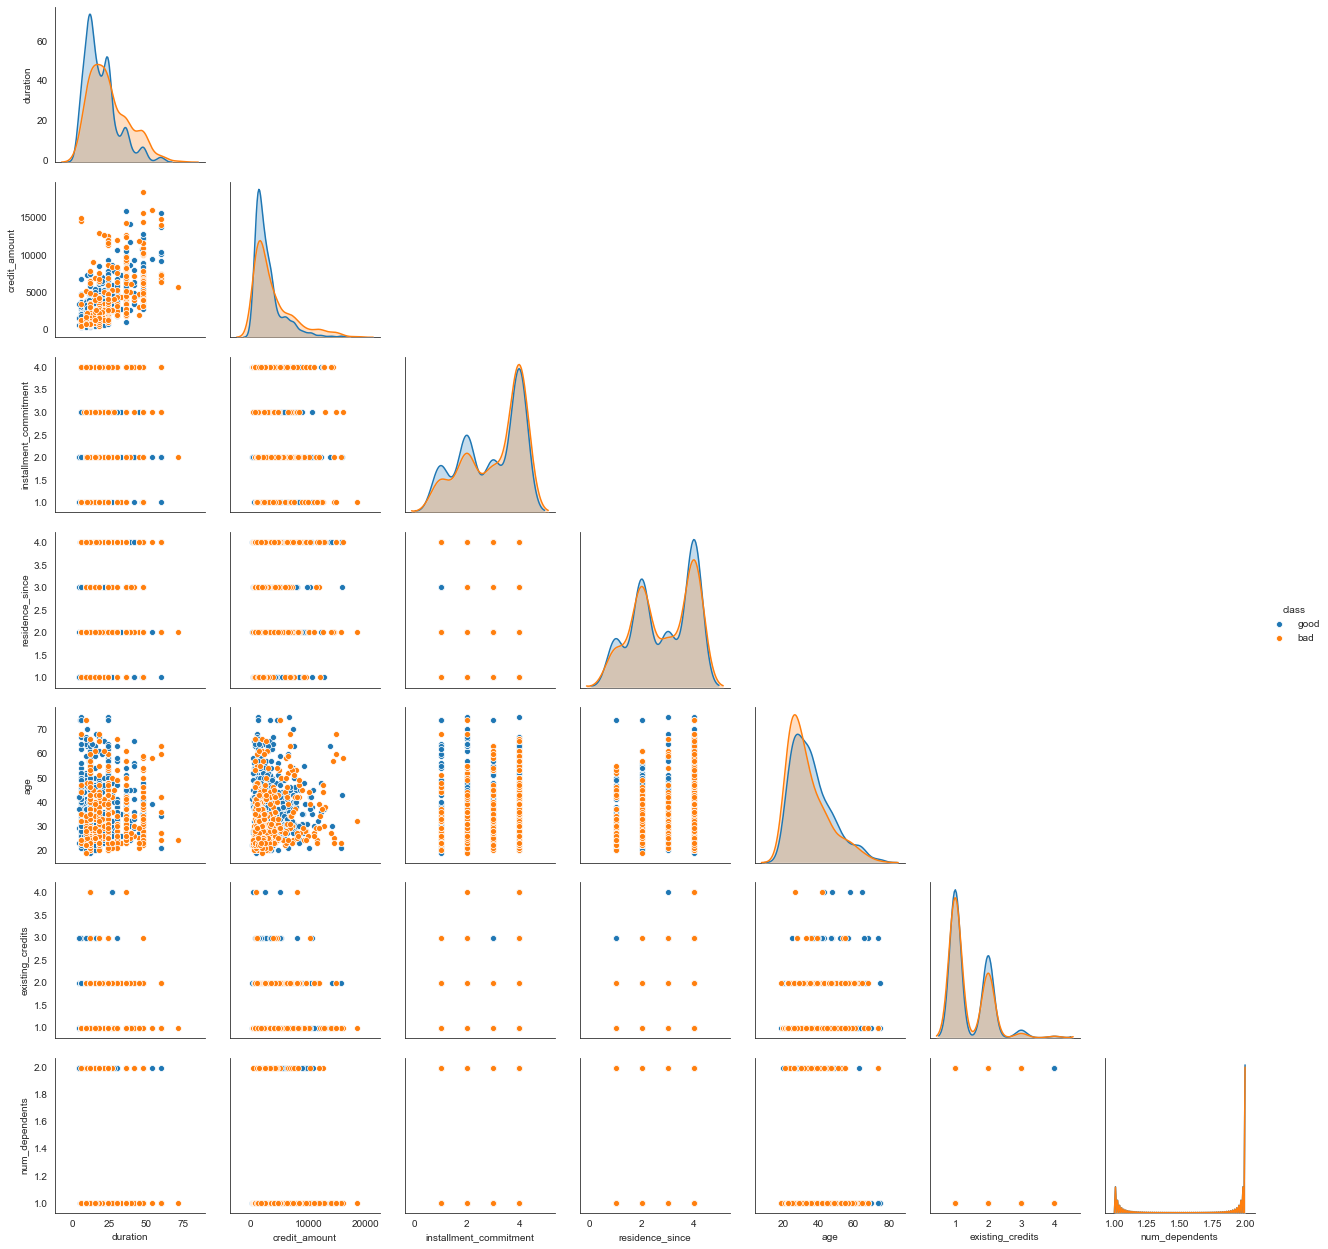

In [225]:
plot_data(all_data)

D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


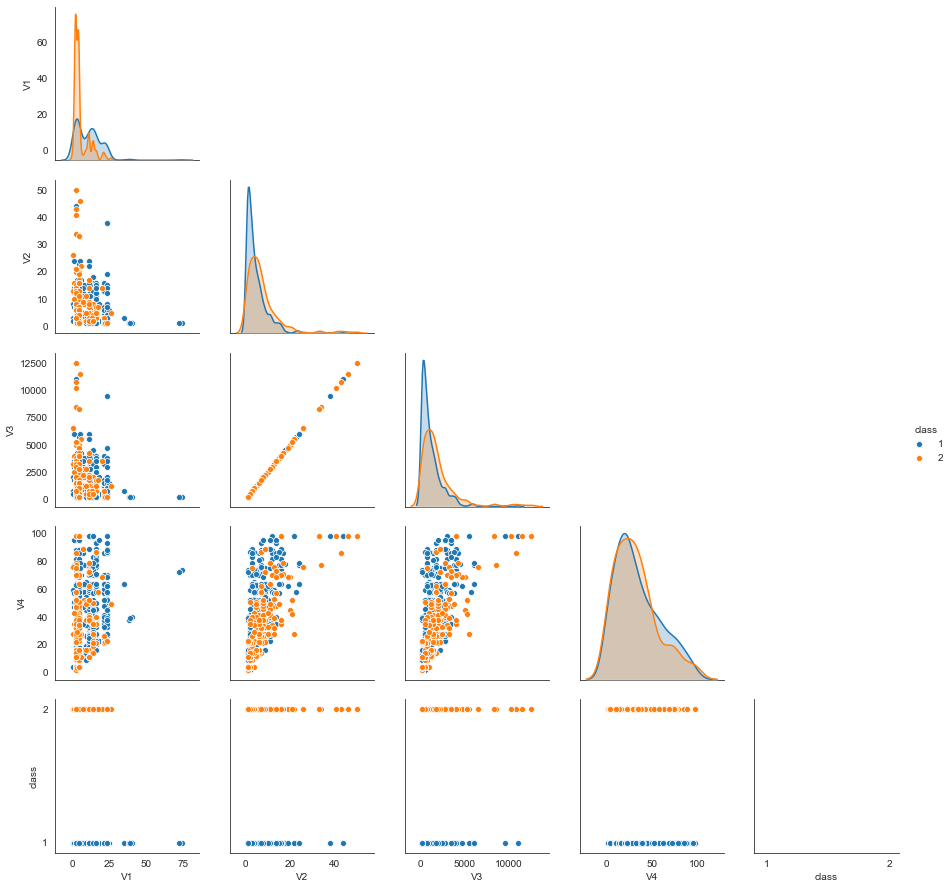

In [226]:
plot_data(all_data_bloodtransfusion)

In [40]:
train_split, test_split = train_test_split(all_data, test_size=0.2)

In [49]:
train_data = train_split[attribute_names]
train_labels = np.array(train_split['class'])

In [52]:
test_data = test_split[attribute_names]
test_labels = np.array(test_split['class'])

In [59]:
def get_train_test_data(all_data, attribute_names):
    ''' Get train and test data along with train and test labels.
    
    Params:
    all_data: dataframe: combined data and labels
    attribute_names: list: names of attributes from the data
    
    Returns:
    train_data: dataframe:
    train_labels: list
    test_data: dataframe
    test_labels: list
    '''
    
    train_split, test_split = train_test_split(all_data, test_size=0.2)
    
    train_data = train_split[attribute_names]
    train_labels = np.array(train_split['class'])
    
    test_data = test_split[attribute_names]
    test_labels = np.array(test_split['class'])
    
    return train_data, train_labels, test_data, test_labels

In [69]:
## test credit-g dataset (openML)
dat_train_credit, lab_train_credit, dat_test_credit, lab_test_credit = get_train_test_data(all_data, attribute_names)

display(dat_train_credit.head())
print(lab_train_credit[0:5])

display(dat_test_credit.head())
print(lab_test_credit[0:5])

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
753,no checking,30.0,critical/other existing credit,radio/tv,5771.0,<100,4<=X<7,4.0,female div/dep/mar,none,2.0,car,25.0,none,own,2.0,skilled,1.0,none,yes
945,0<=X<200,48.0,no credits/all paid,new car,8358.0,500<=X<1000,<1,1.0,female div/dep/mar,none,1.0,car,30.0,none,own,2.0,skilled,1.0,none,yes
652,<0,24.0,existing paid,new car,2303.0,<100,>=7,4.0,male single,co applicant,1.0,real estate,45.0,none,own,1.0,skilled,1.0,none,yes
608,no checking,18.0,existing paid,radio/tv,2051.0,<100,<1,4.0,male single,none,1.0,real estate,33.0,none,own,1.0,skilled,1.0,none,yes
880,no checking,24.0,existing paid,used car,7814.0,<100,4<=X<7,3.0,male single,none,3.0,car,38.0,none,own,1.0,high qualif/self emp/mgmt,1.0,yes,yes


['good' 'good' 'bad' 'good' 'good']


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,7476.0,<100,4<=X<7,4.0,male single,none,1.0,no known property,50.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
412,no checking,12.0,critical/other existing credit,business,2292.0,<100,unemployed,4.0,male single,none,2.0,car,42.0,stores,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,0<=X<200,9.0,existing paid,radio/tv,458.0,<100,1<=X<4,4.0,male single,none,3.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,new car,931.0,100<=X<500,<1,1.0,female div/dep/mar,none,1.0,life insurance,32.0,stores,own,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,furniture/equipment,5179.0,<100,4<=X<7,4.0,male single,none,2.0,life insurance,29.0,none,own,1.0,skilled,1.0,none,yes


['good' 'bad' 'good' 'bad' 'bad']


In [70]:
## test blood-transfusion-service-center dataset (openML)
dat_train_bloodtrandfusion, lab_train_bloodtrandfusion, dat_test_bloodtrandfusion, lab_test_bloodtrandfusion = get_train_test_data(all_data_bloodtransfusion, attribute_names_bloodtransfusion)

display(dat_train_bloodtrandfusion.head())
print(lab_train_bloodtrandfusion[0:5])

display(dat_test_bloodtrandfusion.head())
print(lab_test_bloodtrandfusion[0:5])

,V1,V2,V3,V4
496,38.0,1.0,250.0,38.0
662,16.0,3.0,750.0,21.0
239,8.0,9.0,2250.0,58.0
524,4.0,9.0,2250.0,28.0
79,2.0,2.0,500.0,4.0


['1' '1' '1' '1' '1']


,V1,V2,V3,V4
379,14.0,1.0,250.0,14.0
299,14.0,2.0,500.0,14.0
449,16.0,3.0,750.0,50.0
187,4.0,4.0,1000.0,26.0
287,9.0,2.0,500.0,16.0


['1' '1' '1' '1' '2']


In [82]:
list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == True])

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

In [83]:
list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == False])

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [94]:
#############
class Dataset(ABC):
    def __init__(self, seed, dataset_name):
        
        random.seed(seed)
        np.random.seed(seed)
        
        data = openml.datasets.get_dataset(dataset_name)

        ## summary
        print(f"Dataset '{data.name}', target: '{data.default_target_attribute}'")
        print(data.description[:500])

        ## load the data
        # X: An array/dataframe where each row represents one example with the corresponding feature values
        # y: the classes for each example
        # categorical_indicator - an array that indicates which feature is categorical
        # attribute_names - the names of the features for the examples(X) and target feature (y)
        X, y, categorical_indicator, attribute_names = data.get_data(
            dataset_format='dataframe',
            target=data.default_target_attribute
        )

        ## combine the attribute names with the information of them being categorical or not
        # will be used further in order not to manually distinguish between the numerical and categorical features
        attribute_types = pd.DataFrame(attribute_names, columns=["attribute_names"])
        attribute_types['categorical_indicator'] = categorical_indicator
        print("\nAttribute types: ")
        display(attribute_types)

        all_data = X.copy(deep=True)
        all_data['class'] = y
        
        ## Get train and test data along with train and test labels.
        train_split, test_split = train_test_split(all_data, test_size=0.2)

        train_data = train_split[attribute_names]
        train_labels = np.array(train_split['class'])

        test_data = test_split[attribute_names]
        test_labels = np.array(test_split['class'])

### Model

In [ ]:
## baseline model -- LATER
class BaselineModel(BinaryClassificationTask):
    
    def __init__(self, seed, train_data, train_labels, test_data, test_labels, attribute_types):
        
        categorical_columns = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == True])
        numerical_columms = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == False])
        
        BinaryClassificationTask.__init__(self,
                                          seed,
                                          train_data,
                                          train_labels,
                                          test_data,
                                          test_labels,categorical_columns,
                                          numerical_columms
                                         )
    
    def fit_baseline_model(self, train_data, train_labels, learner):

In [104]:
def fit_model(train_data, train_labels, attribute_types, learner, param_grid):
    ''' Get a trained model.
    
    Params:
    train_data: dataframe
    train_labels: list
    attribute_types: dataframe: names and types of attributes from the data 
    learner: estimator object: estimator to be used
    param_grid: dict: param names as keys and lists of param settings to try as values
    
    Returns:
    categorical_columns
    numerical_columms
    model
    '''
    
    categorical_columns = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == True])
    numerical_columms = list(attribute_types['attribute_names'][attribute_types['categorical_indicator'] == False])
    
    # preprocessing pipeline for numerical columns
    transformer_numeric = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('standard_scale', StandardScaler())
    ])
    
    # preprocessing pipeline for categorical columns
    transformer_categorical = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='__NA__')),
        ('one_hot_encode', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # preprocessor
    feature_transform = ColumnTransformer(transformers=[
        ('categorical_features', transformer_categorical, categorical_columns),
        ('numerical_features', transformer_numeric, numerical_columms)
    ])
    
    ## prediction pipeline: append classifier (learner) to the preprocessing pipeline
    pipeline = Pipeline([
        ('features', feature_transform),
        ('learner', learner)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
    model = grid_search.fit(train_data, train_labels)
    
    return categorical_columns, numerical_columms, model    

In [105]:
## test
from sklearn.linear_model import SGDClassifier

categorical_columns, numerical_columms, model = fit_model(dat_train_credit, lab_train_credit, attribute_types, 
                                                          learner=SGDClassifier(max_iter=1000), 
                                                          param_grid={
                                                              'learner__loss': ['log'],
                                                              'learner__penalty': ['l2', 'l1', 'elasticnet'],
                                                              'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
                                                          })

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.9s finished


In [106]:
categorical_columns

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

In [107]:
numerical_columms

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [108]:
len(categorical_columns)

13

### Corruptions

In [102]:
missing_values_corruption = MissingValues(column="age", fraction=0.45, missingness="MAR", na_value=999)

dat_test_credit_corrupted = missing_values_corruption.transform(dat_test_credit.copy())

In [110]:
## imp
corruptions = {
    'missing': [MissingValues],
    'categorical': [SwappedValues],
    'numeric': [Scaling]
}

In [114]:
list(corruptions.keys())[1]

'categorical'

In [115]:
corruptions['missing']

[jenga.corruptions.generic.MissingValues]

In [144]:
perturb_type = 'numeric'
col_to_perturb = random.choice(numerical_columms)
Scaling(col_to_perturb, 0.5).transform(dat_test_credit.copy())

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,7476.0,<100,4<=X<7,4.0,male single,none,1.0,no known property,50.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
412,no checking,12.0,critical/other existing credit,business,2292.0,<100,unemployed,4.0,male single,none,2.0,car,42.0,stores,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,0<=X<200,9.0,existing paid,radio/tv,458000.0,<100,1<=X<4,4.0,male single,none,3.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,new car,931.0,100<=X<500,<1,1.0,female div/dep/mar,none,1.0,life insurance,32.0,stores,own,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,furniture/equipment,5179.0,<100,4<=X<7,4.0,male single,none,2.0,life insurance,29.0,none,own,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,0<=X<200,9.0,existing paid,education,1199.0,<100,4<=X<7,4.0,female div/dep/mar,none,4.0,life insurance,67.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
558,<0,24.0,all paid,furniture/equipment,3552.0,<100,4<=X<7,3.0,male single,none,4.0,car,27.0,bank,own,1.0,skilled,1.0,none,yes
89,<0,12.0,no credits/all paid,repairs,1108.0,<100,4<=X<7,4.0,male single,none,3.0,real estate,28.0,none,own,2.0,skilled,1.0,none,yes
962,no checking,15.0,existing paid,new car,3556.0,no known savings,1<=X<4,3.0,male single,none,2.0,no known property,29.0,none,own,1.0,skilled,1.0,none,yes


In [145]:
perturb_type = 'categorical'
col_to_perturb = random.sample(categorical_columns, 2)
SwappedValues(col_to_perturb[0], col_to_perturb[1], 0.5).transform(dat_test_credit.copy())

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,7476.0,<100,4<=X<7,4.0,male single,none,1.0,no known property,50.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
412,no checking,12.0,critical/other existing credit,business,2292.0,<100,unemployed,4.0,male single,none,2.0,car,42.0,stores,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,0<=X<200,9.0,existing paid,radio/tv,458.0,real estate,1<=X<4,4.0,male single,none,3.0,<100,24.0,none,own,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,new car,931.0,life insurance,<1,1.0,female div/dep/mar,none,1.0,100<=X<500,32.0,stores,own,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,furniture/equipment,5179.0,life insurance,4<=X<7,4.0,male single,none,2.0,<100,29.0,none,own,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,0<=X<200,9.0,existing paid,education,1199.0,<100,4<=X<7,4.0,female div/dep/mar,none,4.0,life insurance,67.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
558,<0,24.0,all paid,furniture/equipment,3552.0,<100,4<=X<7,3.0,male single,none,4.0,car,27.0,bank,own,1.0,skilled,1.0,none,yes
89,<0,12.0,no credits/all paid,repairs,1108.0,<100,4<=X<7,4.0,male single,none,3.0,real estate,28.0,none,own,2.0,skilled,1.0,none,yes
962,no checking,15.0,existing paid,new car,3556.0,no known savings,1<=X<4,3.0,male single,none,2.0,no known property,29.0,none,own,1.0,skilled,1.0,none,yes


In [146]:
perturb_type = 'missing'
missigness = random.choice(['MCAR', 'MAR', 'MNAR'])
col_to_perturb = random.choice(numerical_columms + categorical_columns)
if col_to_perturb in categorical_columns:
    na_value = '__NA__'
else:
    na_value = 0
MissingValues(col_to_perturb, 0.5, missigness, na_value).transform(dat_test_credit.copy())

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,MAR,<100,4<=X<7,4.0,male single,none,1.0,no known property,50.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
412,no checking,12.0,critical/other existing credit,business,MAR,<100,unemployed,4.0,male single,none,2.0,car,42.0,stores,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,0<=X<200,9.0,existing paid,radio/tv,458,<100,1<=X<4,4.0,male single,none,3.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,new car,931,100<=X<500,<1,1.0,female div/dep/mar,none,1.0,life insurance,32.0,stores,own,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,furniture/equipment,MAR,<100,4<=X<7,4.0,male single,none,2.0,life insurance,29.0,none,own,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,0<=X<200,9.0,existing paid,education,1199,<100,4<=X<7,4.0,female div/dep/mar,none,4.0,life insurance,67.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
558,<0,24.0,all paid,furniture/equipment,MAR,<100,4<=X<7,3.0,male single,none,4.0,car,27.0,bank,own,1.0,skilled,1.0,none,yes
89,<0,12.0,no credits/all paid,repairs,1108,<100,4<=X<7,4.0,male single,none,3.0,real estate,28.0,none,own,2.0,skilled,1.0,none,yes
962,no checking,15.0,existing paid,new car,MAR,no known savings,1<=X<4,3.0,male single,none,2.0,no known property,29.0,none,own,1.0,skilled,1.0,none,yes


In [135]:
numerical_columms + categorical_columns

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents',
 'checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

In [179]:
def random_perturbation(categorical_columns, numerical_columms, fractions=[0.25, 0.5, 0.75, 0.9]):
    ''' Get a random perturbation for a column, chosen from corruptions: missing, numeric, or categorical
    
    Params:
    categorical_columns: list
    numerical_columns: list
    fractions: list: fractions to select from for corruptions
    
    Returns:
    perturbation
    '''
    
    ## get a random perturbation type
    if len(categorical_columns) > 0 and len(numerical_columms) > 0:
        perturb_type = random.choice(list(corruptions.keys()))
    elif len(categorical_columns) > 0:
        perturb_type = 'categorical'
    elif len(numerical_columms) > 0:
        perturb_type = 'numeric'
    
    
    ## get perturbation on a random column based on the perturbation type
    ## update perturbation to random selection when more perturbation types are added to corruptions
    rand_fraction = random.choice(fractions)
    if perturb_type is 'numeric':
        col_to_perturb = random.choice(numerical_columms)
        return Scaling(col_to_perturb, rand_fraction)
    elif perturb_type is 'categorical':
        col_to_perturb = random.sample(categorical_columns, 2)
        return SwappedValues(col_to_perturb[0], col_to_perturb[1], rand_fraction)
    elif perturb_type is 'missing':
        missigness = random.choice(['MCAR', 'MAR', 'MNAR'])
        col_to_perturb = random.choice(numerical_columms + categorical_columns)
        if col_to_perturb in categorical_columns:
            na_value = '__NA__'
        else:
            na_value = 0
        return MissingValues(col_to_perturb, rand_fraction, na_value, missigness)


In [182]:
perturbation = random_perturbation(categorical_columns, numerical_columms)
print(perturbation)
perturbation.transform(dat_test_credit.copy())

Scaling: {'column': 'residence_since', 'fraction': 0.9}


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,7476.0,<100,4<=X<7,4.0,male single,none,100.0,no known property,50.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
412,no checking,12.0,critical/other existing credit,business,2292.0,<100,unemployed,4.0,male single,none,200.0,car,42.0,stores,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,0<=X<200,9.0,existing paid,radio/tv,458.0,<100,1<=X<4,4.0,male single,none,300.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,new car,931.0,100<=X<500,<1,1.0,female div/dep/mar,none,100.0,life insurance,32.0,stores,own,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,furniture/equipment,5179.0,<100,4<=X<7,4.0,male single,none,200.0,life insurance,29.0,none,own,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,0<=X<200,9.0,existing paid,education,1199.0,<100,4<=X<7,4.0,female div/dep/mar,none,400.0,life insurance,67.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
558,<0,24.0,all paid,furniture/equipment,3552.0,<100,4<=X<7,3.0,male single,none,400.0,car,27.0,bank,own,1.0,skilled,1.0,none,yes
89,<0,12.0,no credits/all paid,repairs,1108.0,<100,4<=X<7,4.0,male single,none,300.0,real estate,28.0,none,own,2.0,skilled,1.0,none,yes
962,no checking,15.0,existing paid,new car,3556.0,no known savings,1<=X<4,3.0,male single,none,200.0,no known property,29.0,none,own,1.0,skilled,1.0,none,yes


In [183]:
dat_test_credit

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,7476.0,<100,4<=X<7,4.0,male single,none,1.0,no known property,50.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
412,no checking,12.0,critical/other existing credit,business,2292.0,<100,unemployed,4.0,male single,none,2.0,car,42.0,stores,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,0<=X<200,9.0,existing paid,radio/tv,458.0,<100,1<=X<4,4.0,male single,none,3.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,new car,931.0,100<=X<500,<1,1.0,female div/dep/mar,none,1.0,life insurance,32.0,stores,own,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,furniture/equipment,5179.0,<100,4<=X<7,4.0,male single,none,2.0,life insurance,29.0,none,own,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,0<=X<200,9.0,existing paid,education,1199.0,<100,4<=X<7,4.0,female div/dep/mar,none,4.0,life insurance,67.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
558,<0,24.0,all paid,furniture/equipment,3552.0,<100,4<=X<7,3.0,male single,none,4.0,car,27.0,bank,own,1.0,skilled,1.0,none,yes
89,<0,12.0,no credits/all paid,repairs,1108.0,<100,4<=X<7,4.0,male single,none,3.0,real estate,28.0,none,own,2.0,skilled,1.0,none,yes
962,no checking,15.0,existing paid,new car,3556.0,no known savings,1<=X<4,3.0,male single,none,2.0,no known property,29.0,none,own,1.0,skilled,1.0,none,yes


In [190]:
num_perturbations = 4 # number of perturbations to apply
dat_test_credit_corrupted = dat_test_credit.copy()

perturbations = []
for _ in range(num_perturbations):
    perturbation = random_perturbation(categorical_columns, numerical_columms)
    print(perturbation)
    dat_test_credit_corrupted = perturbation.transform(dat_test_credit_corrupted)
    perturbations.append(perturbation) ## storing for conservation: maybe we want to apply the same set of perturbations again: useful for the CleanML scenarios
    
dat_test_credit_corrupted

SwappedValues: {'column_a': 'employment', 'column_b': 'purpose', 'fraction': 0.5}
SwappedValues: {'column_a': 'foreign_worker', 'column_b': 'property_magnitude', 'fraction': 0.5}
MissingValues: {'column': 'installment_commitment', 'fraction': 0.75, 'na_value': 0, 'missingness': 'MCAR'}
Scaling: {'column': 'age', 'fraction': 0.75}


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,7476.0,<100,4<=X<7,4.0,male single,none,1.0,yes,500.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,no known property
412,no checking,12.0,critical/other existing credit,unemployed,2292.0,<100,business,4.0,male single,none,2.0,car,42.0,stores,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,0<=X<200,9.0,existing paid,1<=X<4,458.0,<100,radio/tv,4.0,male single,none,3.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,<1,931.0,100<=X<500,new car,1.0,female div/dep/mar,none,1.0,life insurance,32.0,stores,own,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,4<=X<7,5179.0,<100,furniture/equipment,4.0,male single,none,2.0,life insurance,290.0,none,own,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,0<=X<200,9.0,existing paid,education,1199.0,<100,4<=X<7,4.0,female div/dep/mar,none,4.0,yes,67.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,life insurance
558,<0,24.0,all paid,4<=X<7,3552.0,<100,furniture/equipment,0.0,male single,none,4.0,car,27.0,bank,own,1.0,skilled,1.0,none,yes
89,<0,12.0,no credits/all paid,4<=X<7,1108.0,<100,repairs,0.0,male single,none,3.0,yes,280.0,none,own,2.0,skilled,1.0,none,real estate
962,no checking,15.0,existing paid,new car,3556.0,no known savings,1<=X<4,3.0,male single,none,2.0,yes,290.0,none,own,1.0,skilled,1.0,none,no known property


In [193]:
print(perturbations[0])

SwappedValues: {'column_a': 'employment', 'column_b': 'purpose', 'fraction': 0.5}


In [194]:
def apply_perturbation(df, num_perturbations, categorical_columns, numerical_columms):
    df_corrupted = df.copy()
    
    perturbations = []
    for _ in range(num_perturbations):
        perturbation = random_perturbation(categorical_columns, numerical_columms)
        print(perturbation)
        
        perturbations.append(perturbation) ## storing for conservation: maybe we want to apply the same set of perturbations again: useful for the CleanML scenarios
        
        df_corrupted = perturbation.transform(df_corrupted)
        
    return df_corrupted, perturbations

In [208]:
dat_test_credit_corrupted, perturbations = apply_perturbation(dat_test_credit, 5, categorical_columns, numerical_columms)
dat_test_credit_corrupted

Scaling: {'column': 'age', 'fraction': 0.75}
SwappedValues: {'column_a': 'housing', 'column_b': 'foreign_worker', 'fraction': 0.25}
MissingValues: {'column': 'housing', 'fraction': 0.25, 'na_value': '__NA__', 'missingness': 'MNAR'}
MissingValues: {'column': 'housing', 'fraction': 0.9, 'na_value': '__NA__', 'missingness': 'MNAR'}
SwappedValues: {'column_a': 'purpose', 'column_b': 'checking_status', 'fraction': 0.75}


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
650,<0,48.0,existing paid,education,7476.0,<100,4<=X<7,4.0,male single,none,1.0,no known property,50.0,none,__NA__,1.0,high qualif/self emp/mgmt,1.0,yes,yes
412,no checking,12.0,critical/other existing credit,business,2292.0,<100,unemployed,4.0,male single,none,2.0,car,42000.0,stores,__NA__,2.0,high qualif/self emp/mgmt,1.0,yes,yes
39,radio/tv,9.0,existing paid,0<=X<200,458.0,<100,1<=X<4,4.0,male single,none,3.0,real estate,24000.0,none,__NA__,1.0,skilled,1.0,none,yes
595,0<=X<200,6.0,all paid,new car,931.0,100<=X<500,<1,1.0,female div/dep/mar,none,1.0,life insurance,32000.0,stores,__NA__,1.0,unskilled resident,1.0,none,yes
840,<0,36.0,existing paid,furniture/equipment,5179.0,<100,4<=X<7,4.0,male single,none,2.0,life insurance,29000.0,none,__NA__,1.0,skilled,1.0,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,education,9.0,existing paid,0<=X<200,1199.0,<100,4<=X<7,4.0,female div/dep/mar,none,4.0,life insurance,67.0,none,__NA__,2.0,high qualif/self emp/mgmt,1.0,yes,yes
558,furniture/equipment,24.0,all paid,<0,3552.0,<100,4<=X<7,3.0,male single,none,4.0,car,27.0,bank,__NA__,1.0,skilled,1.0,none,own
89,repairs,12.0,no credits/all paid,<0,1108.0,<100,4<=X<7,4.0,male single,none,3.0,real estate,28000.0,none,__NA__,2.0,skilled,1.0,none,yes
962,new car,15.0,existing paid,no checking,3556.0,no known savings,1<=X<4,3.0,male single,none,2.0,no known property,29000.0,none,__NA__,1.0,skilled,1.0,none,yes


#### Visualize the original and corrupted test data resp. -- makes sense?

D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


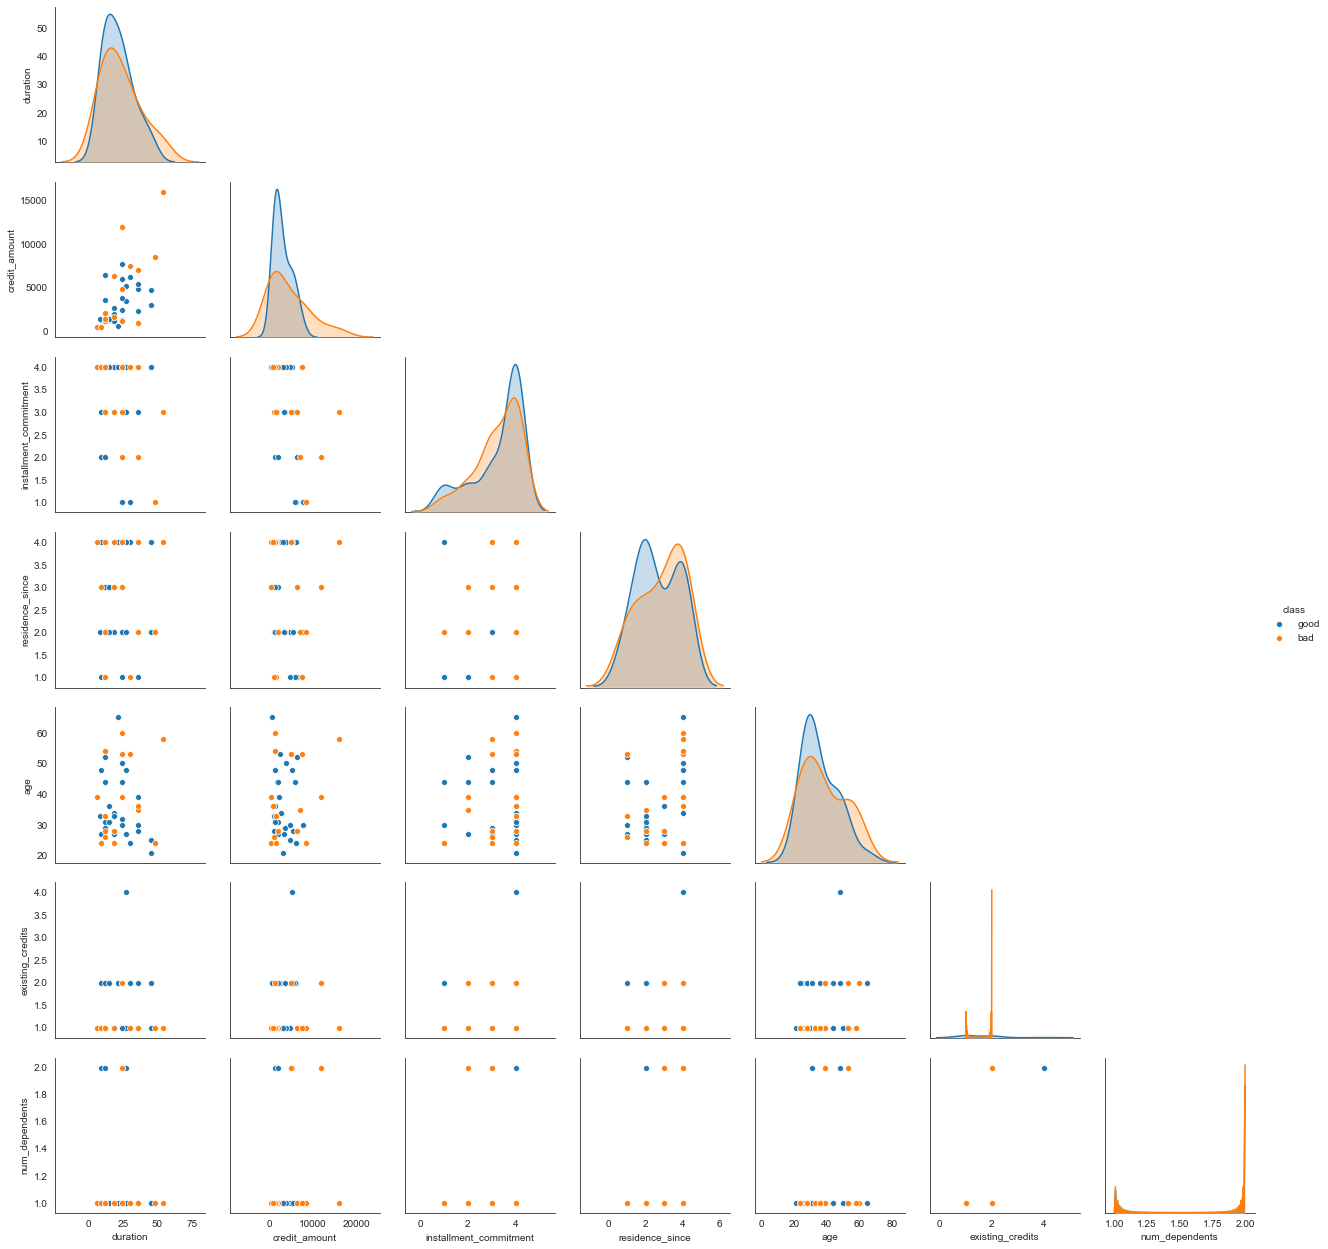

In [231]:
## original test data
plot_data(pd.concat([dat_test_credit, pd.Series(lab_test_credit, name='class')], axis=1))

D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Users\rupal\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


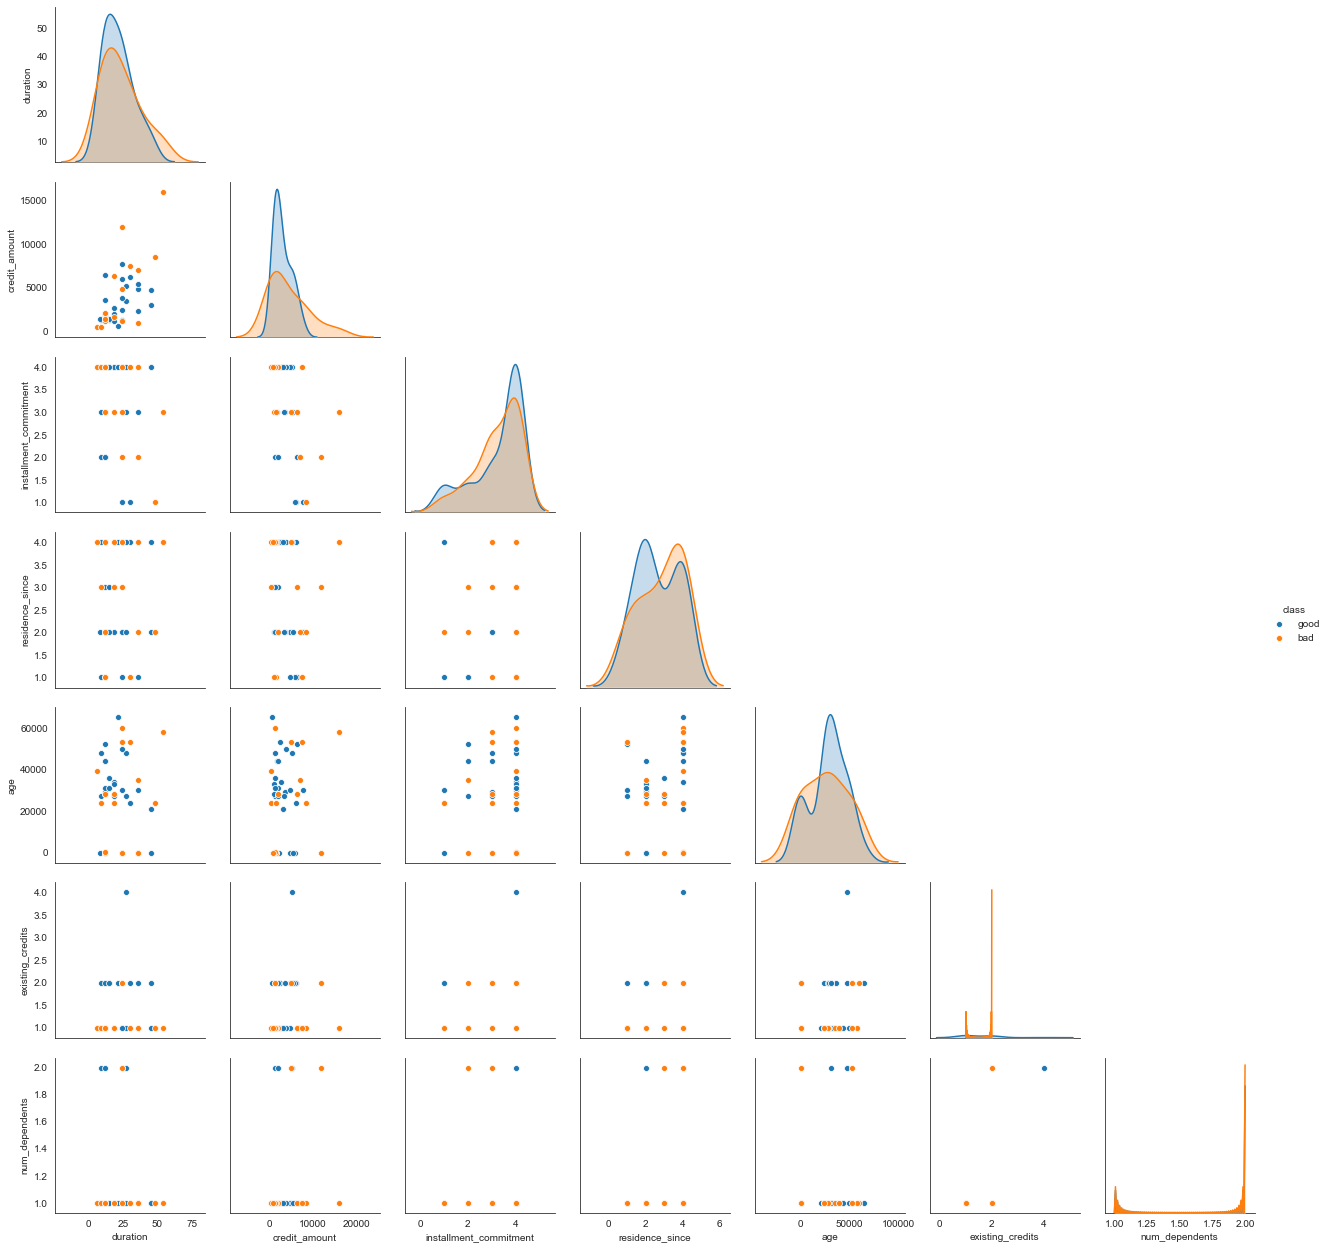

In [232]:
## corrupted test data
plot_data(pd.concat([dat_test_credit_corrupted, pd.Series(lab_test_credit, name='class')], axis=1))

### Cleaning